In [1]:
%matplotlib inline

import matplotlib
import seaborn as sns

In [2]:
import pandas as pd
import numpy as np
from time import time


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix

# Part 1: Prepare data

In [3]:
fileName =  'train.txt'
df = pd.read_csv(fileName, sep='delimiter', header=None)

/home/sarosh/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  from ipykernel import kernelapp as app


In [4]:
df.columns = ['sentence']
df.tail()

,sentence
233995,Zardari refuses to answer questions from polit...
233996,"Zion Kim, 17, of River Edge said the group spe..."
233997,Zul is wellcome to join Perkasa as member only...
233998,ASU increased its graduate enrollment by only ...
233999,"We received death threats earlier, but not now..."


# We are training on 1000 samples out of 233k samples available to us, to try out first

In [5]:
df = df.iloc[np.random.permutation(len(df))]
df = df[0:1000] # subsample from data

In [6]:
s=df['sentence'].str.lower()

In [7]:
dfnew = df.join(s.apply(lambda x: pd.Series(x.split('\t'))))

In [8]:
s = dfnew['sentence']
s = s.map(lambda x: str(x)[0:500])

In [9]:
dfnew.pop(0)
dfnew['sentence']=s
dfnew.columns=['sentence','group','lang']

In [10]:
dfnew.tail()

,sentence,group,lang
60191,"Jika dikombinasikan, trio Wade-Bosh-James mamp...",b,id
41147,Konferencija je bila usredsređena na komercija...,a,sr
147619,A tarifa da água para os munícipes da Póvoa de...,d,pt-pt
69768,SERAMBINEWS.COM - Salah besar jika Anda mengan...,b,id
218768,"And, for it time, it worked for the Tigers, w...",f,en-us


In [11]:
from sklearn.preprocessing import LabelEncoder
unique_classes  = list(set(dfnew['lang']))
unique_classes

['sk',
 'hr',
 'pt-br',
 'sr',
 'pt-pt',
 'en-us',
 'bs',
 'id',
 'en-gb',
 'my',
 'es-es',
 'cz',
 'es-ar']

In [12]:
le = LabelEncoder()
le.fit(unique_classes)
dfnew['lang_category'] = le.transform(dfnew['lang'])

In [13]:
dfnew['sentence_length'] = dfnew['sentence'].str.len()

In [14]:
dfnew.tail()

,sentence,group,lang,lang_category,sentence_length
60191,"Jika dikombinasikan, trio Wade-Bosh-James mamp...",b,id,7,273
41147,Konferencija je bila usredsređena na komercija...,a,sr,12,204
147619,A tarifa da água para os munícipes da Póvoa de...,d,pt-pt,10,165
69768,SERAMBINEWS.COM - Salah besar jika Anda mengan...,b,id,7,400
218768,"And, for it time, it worked for the Tigers, w...",f,en-us,3,130


In [15]:
dfnew['sentence_length'].max()

500

In [16]:
train_size = int(0.7*len(dfnew)) # 70% of all data is for training
x_train = dfnew['sentence'][:train_size]
x_test = dfnew['sentence'][train_size+1:]
y_train = dfnew['lang_category'][:train_size]
y_test = dfnew['lang_category'][train_size+1:]
assert(len(x_train)==len(y_train)) 
assert(len(x_test)==len(y_test)) 

# Part 2: Train a classification model

In [17]:
from sklearn import metrics

import tensorflow as tf
from tensorflow.contrib import learn

In [18]:
MAX_DOCUMENT_LENGTH = 500
HIDDEN_SIZE = 20


def char_rnn_model(x, y):
    """Character level recurrent neural network model to predict classes."""
    y = tf.one_hot(y, len(unique_classes), 1, 0)
    byte_list = learn.ops.one_hot_matrix(x, 256)
    byte_list = tf.unpack(byte_list, axis=1)

    cell = tf.nn.rnn_cell.GRUCell(HIDDEN_SIZE)
    _, encoding = tf.nn.rnn(cell, byte_list, dtype=tf.float32)

    prediction, loss = learn.models.logistic_regression(encoding, y)

    train_op = tf.contrib.layers.optimize_loss(
      loss, tf.contrib.framework.get_global_step(),
      optimizer='Adam', learning_rate=0.01)

    return {'class': tf.argmax(prediction, 1), 'prob': prediction}, loss, train_op

In [19]:
# Process vocabulary
char_processor = learn.preprocessing.ByteProcessor(MAX_DOCUMENT_LENGTH)
x_train_array = np.array(list(char_processor.fit_transform(x_train)))
x_test_array = np.array(list(char_processor.transform(x_test)))

In [20]:
# Build model
classifier = learn.Estimator(model_fn=char_rnn_model)

In [21]:
# Train and predict
classifier.fit(x_train_array, y_train, steps=100)
y_predicted = [
  p['class'] for p in classifier.predict(x_test_array, as_iterable=True)]
score = metrics.accuracy_score(y_test, y_predicted)

# Performance metrics

In [22]:
score

0.45819397993311034

In [24]:
confusion_mat = metrics.confusion_matrix(list(y_test), y_predicted) 
confusion_mat = pd.DataFrame(confusion_mat, columns = unique_classes, index = unique_classes)
confusion_mat

,sk,hr,pt-br,sr,pt-pt,en-us,bs,id,en-gb,my,es-es,cz,es-ar
sk,0,0,0,1,0,0,0,0,0,0,0,0,19
hr,0,12,0,0,0,2,0,0,0,0,0,8,0
pt-br,0,0,5,0,0,0,0,0,0,0,0,0,22
sr,0,0,0,24,0,1,0,0,0,0,0,0,0
pt-pt,0,0,0,0,26,1,0,0,0,0,0,0,0
en-us,0,0,0,0,0,22,0,0,0,0,0,0,0
bs,0,0,0,0,0,0,0,0,0,0,0,0,25
id,0,0,0,1,6,0,0,20,0,0,0,1,0
en-gb,0,0,0,0,0,0,0,0,0,0,0,0,22
my,0,0,0,0,1,21,0,0,0,0,1,0,0


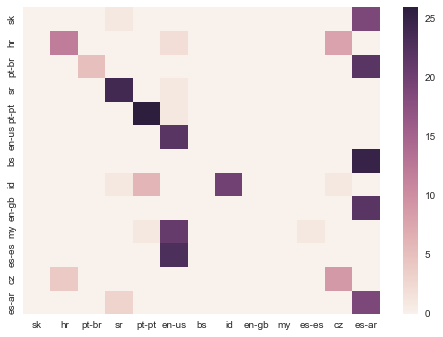

In [25]:
sns.heatmap(confusion_mat)

In [26]:
print(metrics.classification_report(list(y_test), y_predicted, target_names=unique_classes))

             precision    recall  f1-score   support

         sk       0.00      0.00      0.00        20
         hr       0.75      0.55      0.63        22
      pt-br       1.00      0.19      0.31        27
         sr       0.83      0.96      0.89        25
      pt-pt       0.79      0.96      0.87        27
      en-us       0.31      1.00      0.48        22
         bs       0.00      0.00      0.00        25
         id       1.00      0.71      0.83        28
      en-gb       0.00      0.00      0.00        22
         my       0.00      0.00      0.00        23
      es-es       0.00      0.00      0.00        23
         cz       0.50      0.69      0.58        13
      es-ar       0.18      0.86      0.29        22

avg / total       0.44      0.46      0.39       299



/home/sarosh/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Visualizing results

In [32]:
x_test = x_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
y_pred_df = pd.Series(list(le.inverse_transform(list(y_predicted))))
y_test = pd.Series(list(le.inverse_transform(list(y_test))))

In [33]:
df_result = pd.concat([x_test,y_test,y_pred_df],axis=1)
df_result.columns =  ['sentence','ground_truth','prediction']
df_result.head()


,sentence,ground_truth,prediction
0,"""A indústria está sofrendo um ataque de produt...",pt-br,pt-pt
1,"Curtis Edward McCarty, who was twice convicted...",en-us,en-us
2,Robi Draco nació en Nueva York el 27 de junio ...,es-ar,es-ar
3,"Ana Jorge lembrou ainda que, na maioria dos ca...",pt-pt,es-es
4,A observação é de interesse não só para astrôn...,pt-br,es-es


# Common Errors

In [35]:
misclassifications = df_result[df_result['ground_truth']!=df_result['prediction']]
misclassifications

,sentence,ground_truth,prediction
0,"""A indústria está sofrendo um ataque de produt...",pt-br,pt-pt
3,"Ana Jorge lembrou ainda que, na maioria dos ca...",pt-pt,es-es
4,A observação é de interesse não só para astrôn...,pt-br,es-es
5,Ornam as paredes de seu gabinete retratos e pi...,pt-br,es-es
7,"""Ainda é muito cedo, mas talvez tenhamos uma q...",pt-br,es-es
9,Apesar de afirmar que Sarney não pediu uma con...,pt-br,es-es
11,"REPUBLIKA.CO.ID,JAKARTA--Bupati Buol, Sulawesi...",id,es-ar
13,"""As câmaras de Faro e Loulé já transmitiram, p...",pt-pt,es-es
14,O presidente do Conselho Executivo da 'Gonçalv...,pt-pt,es-es
15,"Interpol, organizacija sa sjedištem u Francusk...",hr,sr


# Important Note: These results will significantly improve if we use full data (23k samples) rather than training only with 700 samples and testing on 300 samples